여드름 감지 서비스 모델 (PyTorch, ResNet18기반)

In [7]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import shutil

In [8]:
# 2. GPU 또는 CPU 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [9]:
# 3. 데이터 경로 설정 (로컬 환경, ResNet-18 전용)
BASE_DIR = os.path.join(os.getcwd(), "resized")
IMG_DIR = BASE_DIR
CLASS_DIRS = {
    "normal": os.path.join(BASE_DIR, "normal"),
    "mild": os.path.join(BASE_DIR, "mild"),
    "moderate": os.path.join(BASE_DIR, "moderate"),
    "severe": os.path.join(BASE_DIR, "severe"),
    "very_severe": os.path.join(BASE_DIR, "very_severe")
}
CLASS_ID_MAP = {"normal": 0, "mild": 1, "moderate": 2, "severe": 3, "very_severe": 4}
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
NUM_CLASSES = 5
EPOCHS = 20
BATCH_SIZE = 16

In [10]:
# 데이터 분할 폴더
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 기존 모델 파일 삭제
best_model_path = os.path.join(BASE_DIR, 'best_acne_model.pth')
if os.path.exists(best_model_path):
    os.remove(best_model_path)
    print(f"Deleted existing model: {best_model_path}")
if os.path.exists(os.path.join(BASE_DIR, 'acne_model.pth')):
    os.remove(os.path.join(BASE_DIR, 'acne_model.pth'))
    print("Deleted existing model: acne_model.pth")

Deleted existing model: c:\Users\Admin\work space\2nd\resized\best_acne_model.pth
Deleted existing model: acne_model.pth


In [11]:
# 4. 데이터 전처리: CSV 생성
def is_image(p):
    return os.path.isfile(p) and p.lower().endswith(IMG_EXTS)

rows = []
for label_name, class_dir in CLASS_DIRS.items():
    if os.path.isdir(class_dir):
        class_files = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True) if is_image(p)]
        print(f"[DEBUG] {label_name} files found: {len(class_files)}")
        for fp in class_files:
            rows.append([fp, label_name, CLASS_ID_MAP[label_name]])
    else:
        print(f"[WARN] {label_name} directory not found: {class_dir}")

df = pd.DataFrame(rows, columns=["filepath", "label_name", "label_id"])
out_csv = os.path.join(BASE_DIR, "labels_total.csv")
df.to_csv(out_csv, index=False)
print(f"CSV 생성 완료: {out_csv}")
print("Label distribution:\n", df["label_name"].value_counts())

[DEBUG] normal files found: 936
[DEBUG] mild files found: 359
[DEBUG] moderate files found: 95
[DEBUG] severe files found: 128
[DEBUG] very_severe files found: 90
CSV 생성 완료: c:\Users\Admin\work space\2nd\resized\labels_total.csv
Label distribution:
 label_name
normal         936
mild           359
severe         128
moderate        95
very_severe     90
Name: count, dtype: int64


In [12]:
# 5. 데이터 분할 및 밸런싱
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label_name"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["label_name"], random_state=42)
print("Train dataset size:", len(train_df))
print("Val dataset size:", len(val_df))
print("Test dataset size:", len(test_df))
print("Test dataset class distribution:\n", test_df["label_name"].value_counts())

targets = {"normal": 1000, "mild": 800, "moderate": 800, "severe": 800, "very_severe": 800}
def make_balanced(df, targets):
    rng = np.random.default_rng(42)
    outs = []
    for lab, n in targets.items():
        sub = df[df["label_name"] == lab]
        if len(sub) >= n:
            outs.append(sub.sample(n=n, random_state=42))
        else:
            idx = rng.choice(sub.index.to_numpy(), size=n, replace=True)
            outs.append(df.loc[idx])
    return pd.concat(outs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

train_bal = make_balanced(train_df, targets)
print("Train balanced dataset size:", len(train_bal))
train_bal.to_csv(os.path.join(BASE_DIR, "split_train.balanced.csv"), index=False)
val_df.to_csv(os.path.join(BASE_DIR, "split_val.csv"), index=False)
test_df.to_csv(os.path.join(BASE_DIR, "split_test.csv"), index=False)
print("Train:\n", train_bal["label_name"].value_counts())
print("Val:\n", val_df["label_name"].value_counts())
print("Test:\n", test_df["label_name"].value_counts())

Train dataset size: 1157
Val dataset size: 290
Test dataset size: 161
Test dataset class distribution:
 label_name
normal         94
mild           36
severe         13
very_severe     9
moderate        9
Name: count, dtype: int64
Train balanced dataset size: 4200
Train:
 label_name
normal         1000
mild            800
moderate        800
severe          800
very_severe     800
Name: count, dtype: int64
Val:
 label_name
normal         169
mild            65
severe          23
moderate        17
very_severe     16
Name: count, dtype: int64
Test:
 label_name
normal         94
mild           36
severe         13
very_severe     9
moderate        9
Name: count, dtype: int64


In [13]:
# 폴더 구조 생성
def organize_folders(csv_df, dest_folder):
    for _, row in csv_df.iterrows():
        label = row['label_name']
        src_path = row['filepath']
        dest_label_dir = os.path.join(dest_folder, label)
        os.makedirs(dest_label_dir, exist_ok=True)
        dest_path = os.path.join(dest_label_dir, os.path.basename(src_path))
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

organize_folders(train_bal, train_dir)
organize_folders(val_df, val_dir)
organize_folders(test_df, test_dir)
print("폴더 구조 생성 완료!")

폴더 구조 생성 완료!


In [14]:
# 6. 데이터 로딩: transforms와 DataLoader
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print("클래스 매핑:", train_dataset.class_to_idx)

클래스 매핑: {'mild': 0, 'moderate': 1, 'normal': 2, 'severe': 3, 'very_severe': 4}


In [15]:
# 7. 모델 정의: ResNet-18 전이 학습
class AcneClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(AcneClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(0.3)  # 드롭아웃 감소
        )

    def forward(self, x):
        return self.model(x)

model = AcneClassifier(num_classes=NUM_CLASSES)
model.to(DEVICE)

c:\Users\Admin\miniconda3\envs\project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AcneClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [16]:
# 8. 학습 설정
class_counts = train_bal["label_name"].value_counts()
weights = torch.tensor([1.0 / class_counts[cls] * 2 if cls in ['severe', 'very_severe'] else 1.0 / class_counts[cls] for cls in CLASS_ID_MAP.keys()], dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 학습률 증가
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# 조기 종료 설정
patience = 5
best_val_loss = float('inf')
counter = 0
best_model_path = os.path.join(BASE_DIR, 'best_acne_model.pth')

In [17]:
# 9. 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 조기 종료
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)

Epoch 1/20: 100%|██████████| 82/82 [01:10<00:00,  1.17it/s]


Epoch 1/20 - Train Loss: 0.8781, Train Acc: 0.6877, Val Loss: 0.2700, Val Acc: 0.8967
Best model saved with Val Loss: 0.2700


Epoch 2/20: 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]


Epoch 2/20 - Train Loss: 0.6244, Train Acc: 0.7764, Val Loss: 0.2319, Val Acc: 0.9174
Best model saved with Val Loss: 0.2319


Epoch 3/20: 100%|██████████| 82/82 [01:44<00:00,  1.27s/it]


Epoch 3/20 - Train Loss: 0.6110, Train Acc: 0.7433, Val Loss: 0.2298, Val Acc: 0.9029
Best model saved with Val Loss: 0.2298


Epoch 4/20: 100%|██████████| 82/82 [02:02<00:00,  1.50s/it]


Epoch 4/20 - Train Loss: 0.5160, Train Acc: 0.7857, Val Loss: 0.1807, Val Acc: 0.9277
Best model saved with Val Loss: 0.1807


Epoch 5/20: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]


Epoch 5/20 - Train Loss: 0.5075, Train Acc: 0.8072, Val Loss: 0.1484, Val Acc: 0.9421
Best model saved with Val Loss: 0.1484


Epoch 6/20: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]


Epoch 6/20 - Train Loss: 0.5048, Train Acc: 0.8003, Val Loss: 0.1480, Val Acc: 0.9483
Best model saved with Val Loss: 0.1480


Epoch 7/20: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]


Epoch 7/20 - Train Loss: 0.4309, Train Acc: 0.7995, Val Loss: 0.0961, Val Acc: 0.9711
Best model saved with Val Loss: 0.0961


Epoch 8/20: 100%|██████████| 82/82 [01:06<00:00,  1.23it/s]


Epoch 8/20 - Train Loss: 0.3851, Train Acc: 0.8358, Val Loss: 0.0716, Val Acc: 0.9814
Best model saved with Val Loss: 0.0716


Epoch 9/20: 100%|██████████| 82/82 [01:05<00:00,  1.25it/s]


Epoch 9/20 - Train Loss: 0.4734, Train Acc: 0.8250, Val Loss: 0.1406, Val Acc: 0.9463


Epoch 10/20: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]


Epoch 10/20 - Train Loss: 0.3632, Train Acc: 0.8350, Val Loss: 0.0710, Val Acc: 0.9731
Best model saved with Val Loss: 0.0710


Epoch 11/20: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]


Epoch 11/20 - Train Loss: 0.3682, Train Acc: 0.8396, Val Loss: 0.0834, Val Acc: 0.9752


Epoch 12/20: 100%|██████████| 82/82 [01:01<00:00,  1.32it/s]


Epoch 12/20 - Train Loss: 0.3985, Train Acc: 0.8458, Val Loss: 0.0404, Val Acc: 0.9897
Best model saved with Val Loss: 0.0404


Epoch 13/20: 100%|██████████| 82/82 [01:01<00:00,  1.33it/s]


Epoch 13/20 - Train Loss: 0.3330, Train Acc: 0.8419, Val Loss: 0.0467, Val Acc: 0.9793


Epoch 14/20: 100%|██████████| 82/82 [01:03<00:00,  1.29it/s]


Epoch 14/20 - Train Loss: 0.3277, Train Acc: 0.8612, Val Loss: 0.0516, Val Acc: 0.9814


Epoch 15/20: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]


Epoch 15/20 - Train Loss: 0.2886, Train Acc: 0.8489, Val Loss: 0.0435, Val Acc: 0.9814


Epoch 16/20: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s]


Epoch 16/20 - Train Loss: 0.4140, Train Acc: 0.8365, Val Loss: 0.0378, Val Acc: 0.9835
Best model saved with Val Loss: 0.0378


Epoch 17/20: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]


Epoch 17/20 - Train Loss: 0.2898, Train Acc: 0.8551, Val Loss: 0.0310, Val Acc: 0.9897
Best model saved with Val Loss: 0.0310


Epoch 18/20: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s]


Epoch 18/20 - Train Loss: 0.3168, Train Acc: 0.8658, Val Loss: 0.0381, Val Acc: 0.9855


Epoch 19/20: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]


Epoch 19/20 - Train Loss: 0.2870, Train Acc: 0.8566, Val Loss: 0.0511, Val Acc: 0.9835


Epoch 20/20: 100%|██████████| 82/82 [01:02<00:00,  1.32it/s]


Epoch 20/20 - Train Loss: 0.3163, Train Acc: 0.8412, Val Loss: 0.0319, Val Acc: 0.9938


In [18]:
# 10. 모델 저장
torch.save(model.state_dict(), os.path.join(BASE_DIR, 'acne_model.pth'))
print("모델 저장 완료!")

모델 저장 완료!


In [19]:
# 11. 테스트 및 평가
try:
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Using current model weights instead. Please ensure re-training with ResNet-18.")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

Loaded best model from c:\Users\Admin\work space\2nd\resized\best_acne_model.pth


In [20]:
# 예측된 클래스 확인
unique_preds = np.unique(y_pred)
print("Predicted classes:", [list(CLASS_ID_MAP.keys())[i] for i in unique_preds])

Predicted classes: ['normal', 'mild', 'moderate', 'severe', 'very_severe']


In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(CLASS_ID_MAP.keys()), zero_division=0))


Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.96      0.96        54
        mild       0.92      0.79      0.85        14
    moderate       0.99      1.00      1.00       141
      severe       0.73      0.84      0.78        19
 very_severe       0.83      0.71      0.77        14

    accuracy                           0.95       242
   macro avg       0.89      0.86      0.87       242
weighted avg       0.95      0.95      0.95       242



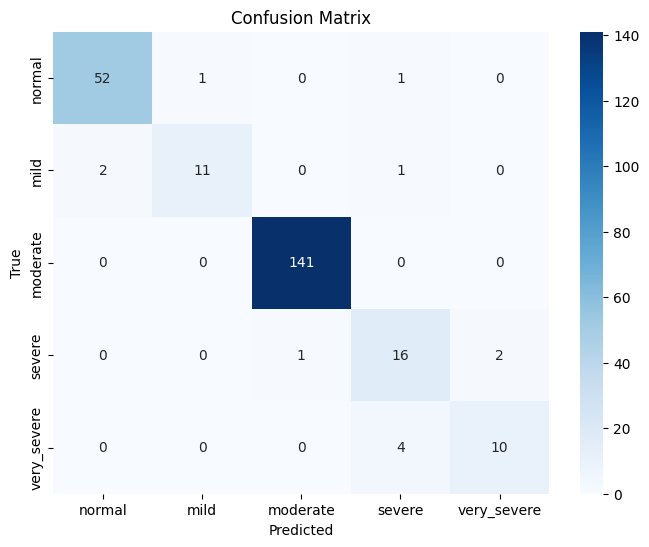

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(CLASS_ID_MAP.keys()), yticklabels=list(CLASS_ID_MAP.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

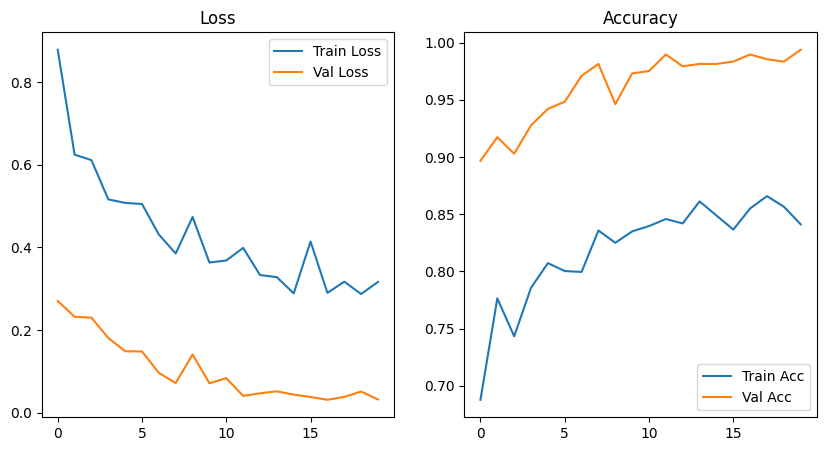

In [23]:
# 12. 손실 및 정확도 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()